# Lesson 1 - Pet Classifier

So the first lesson was an image classifier using the fast.ai library. Giving us an overview of how the general flow of experimenting with an ML model, basically how to get around feeding it the data to train it, and some of the parameters that play an important role in this flow. Like the batch size, I have assumed this training of ML models was resource intensive, but did not know it was THIS much!

Most of what follows is specifically using the fast.ai library which is like a front label in top of Pytorch. So what I'm trying to do in this little experiment is basically try to get the same output of the lesson, but playing around with the library to feed the data differently.

In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [16]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [17]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

#### Original dataset used for this lesson
We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

#### Dataset I used to experiment
I used a dataset containing [fashion product images found](https://www.kaggle.com/paramaggarwal/fashion-product-images-small) found in the Kaggle platform, which is something heavily mentioned in this lesson. And is also the reason why I wanted to clean up this notebook as much as possible because of the nuances of how I managed to feed fetch the data from that dataset and feed the model. Just wanted to get to the same place but taking a different route.

In [18]:
path = Path('../../../storage/myntradataset')

In [19]:
path.ls()

[PosixPath('../../../storage/myntradataset/images'),
 PosixPath('../../../storage/myntradataset/styles.csv'),
 PosixPath('../../../storage/myntradataset/.ipynb_checkpoints')]

In [20]:
# Setting up the random seed so that the validation set is the same, so we can reproduce the results
np.random.seed(2)

### THIS BELOW BLEW MY MIND, JUST SAYING
What I had done previously with res.Future came in handy here, because I could reference the data (train & validation sets) from a panda DataFrame!!💥🐼

In [21]:
df = pd.read_csv(path/'styles.csv', error_bad_lines=False)
df.head()

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


I was having trouble getting past here, basically this dataset contains some missing references. I did not wanted to go over `all` of them so I limited the dataset after realizing that below id#10000 I could continue

In [22]:
df = df[df.id < 10000]

This below is basically fast.ai's way of providing the data specifically for the model. Very opinionated so I hope that later down the road I get to see more of the underlying library (Pytorch), which I assume is less specific so we can tweak the feeding to be the Resonance way

In [23]:
data = ImageDataBunch.from_df(path=path, df=df, folder=path/'images', suffix='.jpg', fn_col=0, label_col=4, ds_tfms=get_transforms(), size=60)

/opt/conda/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Shoe Laces
  if getattr(ds, 'warn', False): warn(ds.warn)


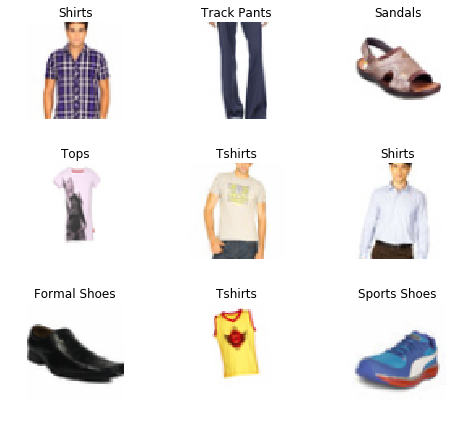

In [24]:
data.show_batch(rows=3, figsize=(7,6))

In [25]:
print(data.classes)
len(data.classes),data.c

['Backpacks', 'Basketballs', 'Belts', 'Bra', 'Capris', 'Caps', 'Casual Shoes', 'Dresses', 'Duffel Bag', 'Flats', 'Flip Flops', 'Footballs', 'Formal Shoes', 'Handbags', 'Headband', 'Heels', 'Jackets', 'Jeans', 'Kurtas', 'Laptop Bag', 'Leggings', 'Lounge Pants', 'Messenger Bag', 'Rucksacks', 'Sandals', 'Shirts', 'Shoe Accessories', 'Shorts', 'Skirts', 'Socks', 'Sports Sandals', 'Sports Shoes', 'Sunglasses', 'Sweaters', 'Sweatshirts', 'Swimwear', 'Tops', 'Track Pants', 'Tracksuits', 'Travel Accessory', 'Trousers', 'Tshirts', 'Tunics', 'Waist Pouch', 'Waistcoat', 'Wallets', 'Watches', 'Water Bottle', 'Wristbands']


(49, 49)

## Training: resnet34

Using resnet34, still just scratching the surface here. Was recommended in the lesson so I'm gonna stick to that, but I should expect to dive deeper into some other architectures for the models.

In [26]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [27]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [28]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.745825,1.248428,0.326072,00:09
1,1.663055,1.075474,0.306395,00:08
2,1.282459,0.947913,0.300773,00:08
3,1.071045,0.813900,0.252987,00:08
4,0.953054,0.807760,0.248770,00:08


In [29]:
learn.save('stage-1')

## Results

In [30]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

Not state of the art, but pretty cool what I could do only 2 hours in!

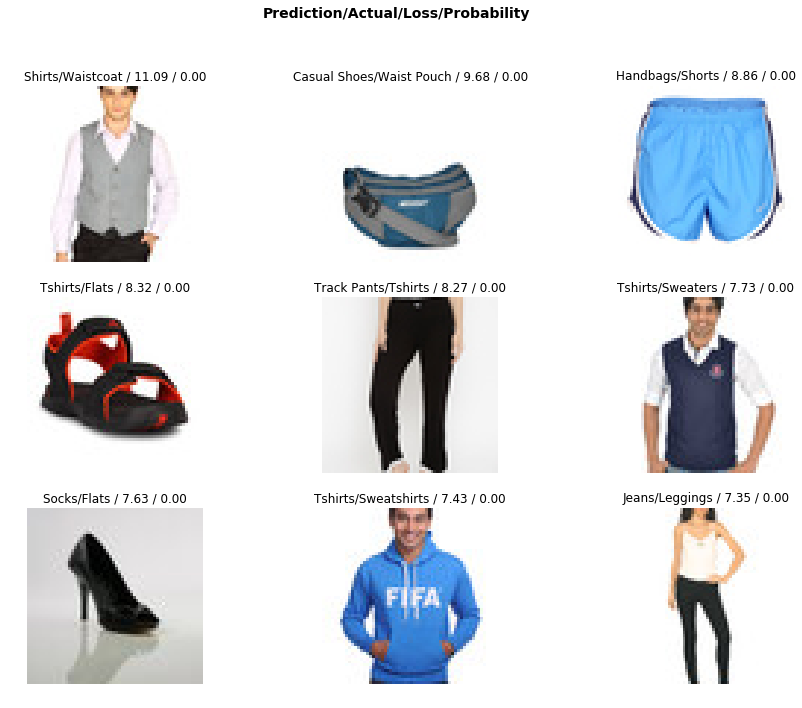

In [31]:
interp.plot_top_losses(9, figsize=(15,11))

In [32]:
doc(interp.plot_top_losses)

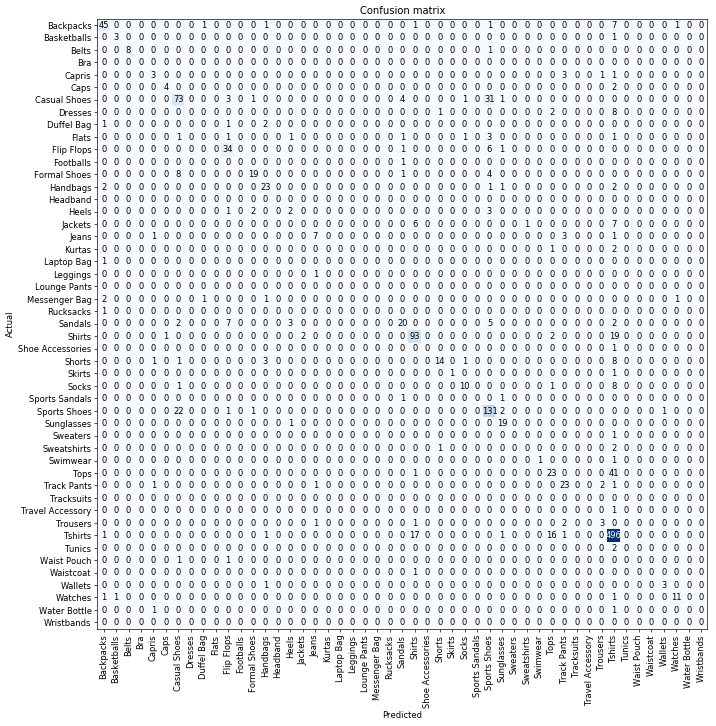

In [33]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 11),
 ('Birman', 'Ragdoll', 7),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Ragdoll', 'Birman', 5),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('american_pit_bull_terrier', 'miniature_pinscher', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Maine_Coon', 'Persian', 2),
 ('Persian', 'Maine_Coon', 2),
 ('Siamese', 'Ragdoll', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('basset_hound', 'beagle', 2),
 ('boxer', 'american_bulldog', 2),
 ('miniature_pinscher', 'chihuahua', 2)]

## Other techniques to fine-train the model after the initial train

Basically unfreezing it to train it some more. I believe that models in production somewhat do this to continue learning

In [34]:
learn.unfreeze()

In [35]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.993018,0.675557,0.217850,00:12


In [25]:
learn.load('stage-1');

In [36]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


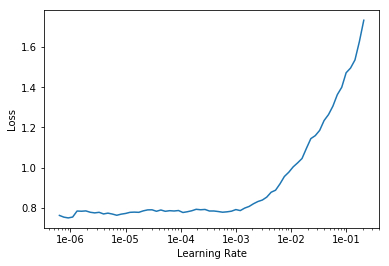

In [37]:
learn.recorder.plot()

Introduced the learning rate and how it can be an indicator of:
1. How to keep fine-tuning a model
2. How well a model has been trained

In [38]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.731735,0.597118,0.200281,00:11
1,0.693887,0.582895,0.200281,00:11


With the staled error_rate gives me to think that I may have overtrained the model 😅

## Other data formats

#### Below are other ways of feeding the data to a model. Left them here as a

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

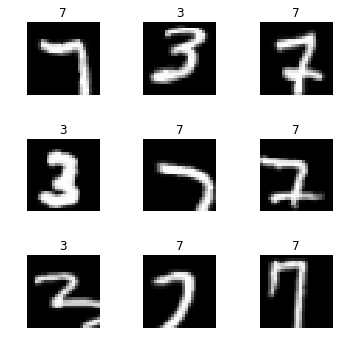

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [ ]:
help(ImageDataBunch)

In [8]:
doc(ImageDataBunch.from_csv)

In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

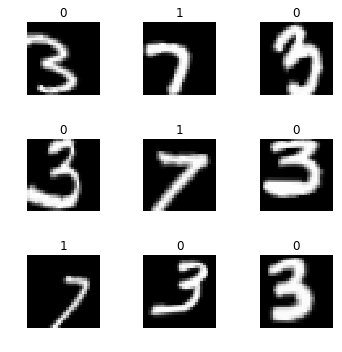

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']